<a href="https://colab.research.google.com/github/bsbyers/REE/blob/main/REE_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
from matplotlib.ticker import MaxNLocator
import re
import plotly.graph_objects as go
import textwrap


In [92]:


# 1. Load & filter
df = pd.read_csv('review_583604_20250614024919 (1).csv')
df_consensus = df[df['Reviewer Name'] == 'Consensus'].reset_index(drop=True)

# 2. Define section boundaries by 0-based index
metadata_cols = df.columns[:11]    # cols 0–10
feed1_cols     = df.columns[11:123]  # cols 11–122
feed2_cols     = df.columns[123:235] # cols 123–234
feed3_cols     = df.columns[235:347] # cols 235–346
section4_cols  = df.columns[347:]    # cols 347+

# sanity check: all feed blocks must be same width
assert len(feed1_cols) == len(feed2_cols) == len(feed3_cols)

# 3. “Melt” the three feedstock blocks into one
rows = []
for _, row in df_consensus.iterrows():
    for block in (feed1_cols, feed2_cols, feed3_cols):
        if row[block].notna().any():  # only if any data in this block
            rec = {c: row[c] for c in metadata_cols}   # paper‐level metadata
            # map this block into the feed1 slot
            for i, col in enumerate(feed1_cols):
                rec[col] = row[block[i]]
            # append section‐4 columns unchanged
            for c in section4_cols:
                rec[c] = row[c]
            rows.append(rec)

df_melted = pd.DataFrame(rows, columns=list(metadata_cols) + list(feed1_cols) + list(section4_cols))




In [93]:
#from IPython.display import display
#display(df_melted)   # shows the full frame (with scrollbars if very wide)


df_melted.head()    # first 5 rows
df_melted.tail()    # last 5 rows
#df_melted.sample(10)  # a random 10 rows


,Covidence #,Study ID,Title,Reviewer Name,Paper Title,Journal Name,Year of Publication,Author Institutions,Institutions' Countries,Study design,REEs Studied,Geographic source - FIRST FEEDSTOCK,Main Category - FIRST FEEDSTOCK,Secondary Category - FIRST FEEDSTOCK,REEs Recovered - First Feedstock:,Cerium (Ce) REE conc. in feedstock,Cerium (Ce) units,Cerium (Ce) Purity of leached REE,Cerium (Ce) units.1,Cerium (Ce) REE recovery yield,Cerium (Ce) units.2,Dysprosium (Dy) REE conc. in feedstock,Dysprosium (Dy) units,Dysprosium (Dy) Purity of leached REE,Dysprosium (Dy) units.1,Dysprosium (Dy) REE recovery yield,Dysprosium (Dy) units.2,Erbium (Er) REE conc. in feedstock,Erbium (Er) units,Erbium (Er) Purity of leached REE,Erbium (Er) units.1,Erbium (Er) REE recovery yield,Erbium (Er) units.2,Europium (Eu) REE conc. in feedstock,Europium (Eu) units,Europium (Eu) Purity of leached REE,Europium (Eu) units.1,Europium (Eu) REE recovery yield,Europium (Eu) units.2,Gadolinium (Gd) REE conc. in feedstock,Gadolinium (Gd) units,Gadolinium (Gd) Purity of leached REE,Gadolinium (Gd) units.1,Gadolinium (Gd) REE recovery yield,Gadolinium (Gd) units.2,Holmium (Ho) REE conc. in feedstock,Holmium (Ho) units,Holmium (Ho) Purity of leached REE,Holmium (Ho) units.1,Holmium (Ho) REE recovery yield,Holmium (Ho) units.2,Lanthanum (La) REE conc. in feedstock,Lanthanum (La) units,Lanthanum (La) Purity of leached REE,Lanthanum (La) units.1,Lanthanum (La) REE recovery yield,Lanthanum (La) units.2,Lutetium (Lu) REE conc. in feedstock,Lutetium (Lu) units,Lutetium (Lu) Purity of leached REE,Lutetium (Lu) units.1,Lutetium (Lu) REE recovery yield,Lutetium (Lu) units.2,Neodymium (Nd) REE conc. in feedstock,Neodymium (Nd) units,Neodymium (Nd) Purity of leached REE,Neodymium (Nd) units.1,Neodymium (Nd) REE recovery yield,Neodymium (Nd) units.2,Promethium (Pm) REE conc. in feedstock,Promethium (Pm) units,Promethium (Pm) Purity of leached REE,Promethium (Pm) units.1,Promethium (Pm) REE recovery yield,Promethium (Pm) units.2,Praseodymium (Pr) REE conc. in feedstock,Praseodymium (Pr) units,Praseodymium (Pr) Purity of leached REE,Praseodymium (Pr) units.1,Praseodymium (Pr) REE recovery yield,Praseodymium (Pr) units.2,Scandium (Sc) REE conc. in feedstock,Scandium (Sc) units,Scandium (Sc) Purity of leached REE,Scandium (Sc) units.1,Scandium (Sc) REE recovery yield,Scandium (Sc) units.2,Samarium (Sm) REE conc. in feedstock,Samarium (Sm) units,Samarium (Sm) Purity of leached REE,Samarium (Sm) units.1,Samarium (Sm) REE recovery yield,Samarium (Sm) units.2,Terbium (Tb) REE conc. in feedstock,Terbium (Tb) units,Terbium (Tb) Purity of leached REE,Terbium (Tb) units.1,Terbium (Tb) REE recovery yield,Terbium (Tb) units.2,Thulium (Tm) REE conc. in feedstock,Thulium (Tm) units,Thulium (Tm) Purity of leached REE,Thulium (Tm) units.1,Thulium (Tm) REE recovery yield,Thulium (Tm) units.2,Yttrium (Y) REE conc. in feedstock,Yttrium (Y) units,Yttrium (Y) Purity of leached REE,Yttrium (Y) units.1,Yttrium (Y) REE recovery yield,Yttrium (Y) units.2,Ytterbium (Yb) REE conc. in feedstock,Ytterbium (Yb) units,Ytterbium (Yb) Purity of leached REE,Ytterbium (Yb) units.1,Ytterbium (Yb) REE recovery yield,Ytterbium (Yb) units.2,RE Oxides (General) REE conc. in feedstock,RE Oxides (General) units,RE Oxides (General) Purity of leached REE,RE Oxides (General) units.1,RE Oxides (General) REE recovery yield,RE Oxides (General) units.2,Extraction Method,Co-/By-Products during Recovery,Circular Economy Strategy,Lifecycle Stage of Intervention,Key Feedstock Logistical,Economic Information,Additional Notes
4,493,AbouEl‑Anwar 2025,Mining and industrial processing wastes of pho...,Consensus,Mining and industrial processing wastes of pho...,International Journal of Environmental Science...,2025,National Research Centre; Ministry of Environm...,Egypt; China,Experimental (Lab Study); Economic Assessment ...,Cerium (Ce); Lanthanum (La); Neodymium (Nd); S...,Other: Egypt,Industrial Residues (IR),IR: Process Tailings an

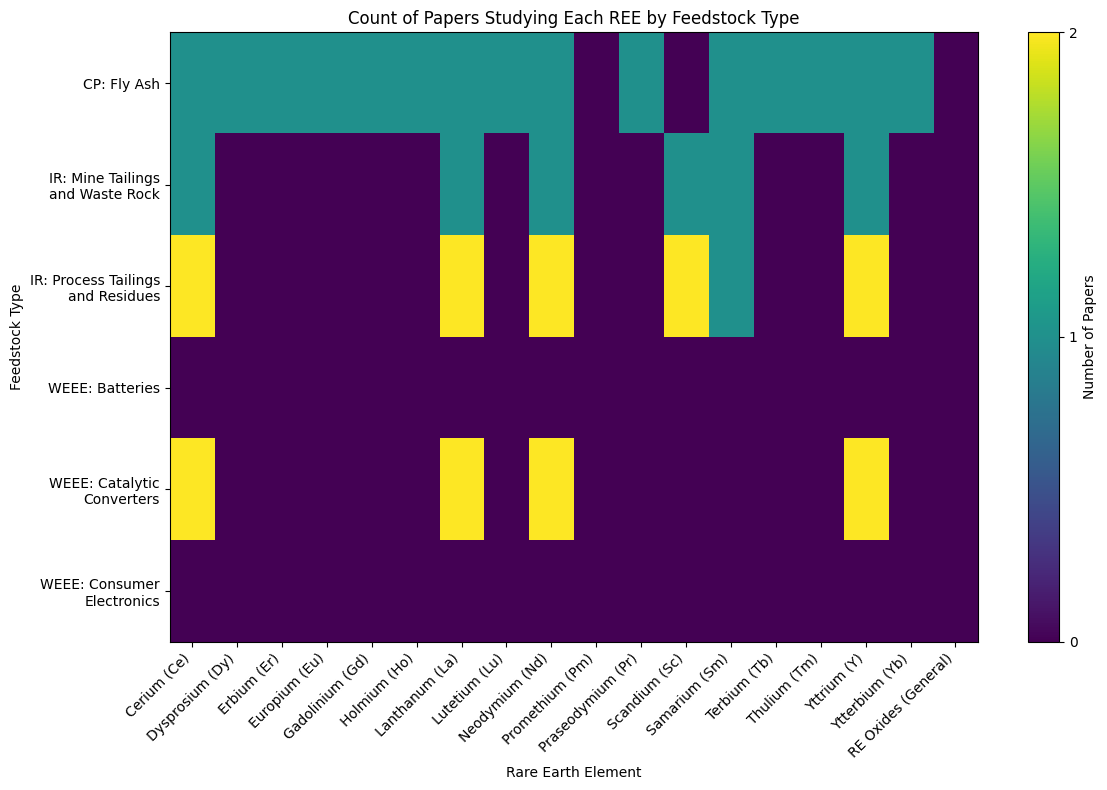

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import textwrap


# 4. Identify the REE concentration columns (numeric) in the feed1 block
ree_cols = [col for col in feed1_cols if 'REE conc. in feedstock' in col]

# 5. Identify the Secondary Category column name in feed1_cols
sec_cat_col = [c for c in feed1_cols if 'Secondary Category' in c][0]

# 6. Count non-empty entries per REE by feedstock type
pivot_counts = df_melted.groupby(sec_cat_col)[ree_cols].apply(lambda x: x.notna().sum())

# 7. Wrap y-axis labels (Feedstock Type)
wrapped_labels = [
    "\n".join(textwrap.wrap(label, width=20))
    for label in pivot_counts.index
]

# 8. Plot heatmap of counts with integer-only colorbar
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(pivot_counts.values, aspect='auto')
cb = fig.colorbar(im, ax=ax)
cb.ax.yaxis.set_major_locator(MaxNLocator(integer=True))
cb.set_label('Number of Papers')

# Set axis ticks and labels
ax.set_xticks(range(len(ree_cols)))
ax.set_xticklabels([col.split(' REE')[0] for col in ree_cols], rotation=45, ha='right')
ax.set_yticks(range(len(wrapped_labels)))
ax.set_yticklabels(wrapped_labels)
ax.set_xlabel('Rare Earth Element')
ax.set_ylabel('Feedstock Type')
ax.set_title('Count of Papers Studying Each REE by Feedstock Type')

plt.tight_layout()
plt.show()


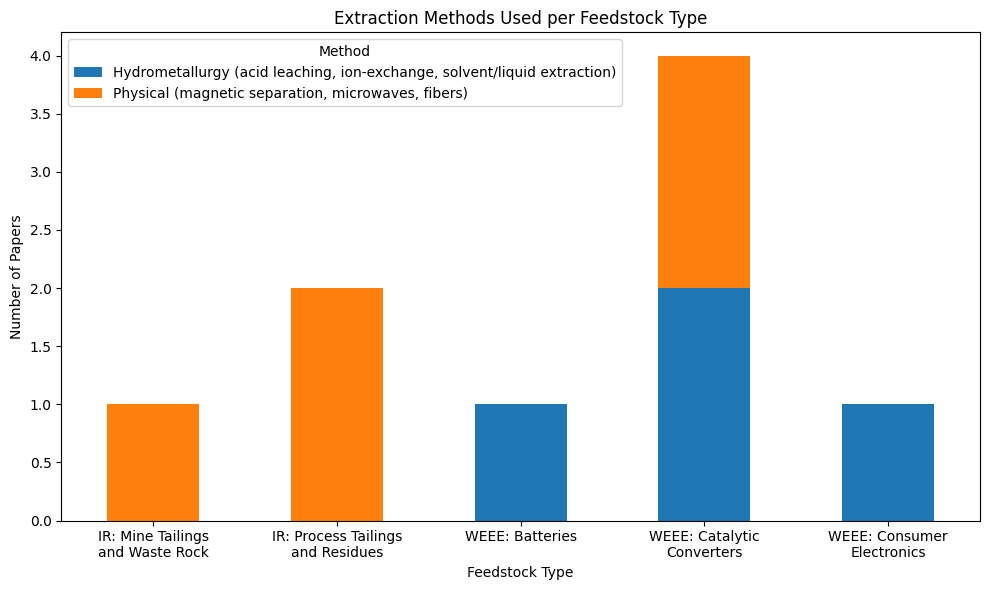

In [95]:
# ----- Figure 1: Extraction Method Frequency (split on ';') -----
df_extract = df_melted[[sec_cat_col, 'Extraction Method']].dropna()
df_extract = df_extract.assign(
    Method=df_extract['Extraction Method'].str.split(';')
).explode('Method')
df_extract['Method'] = df_extract['Method'].str.strip()

count_extract = df_extract.groupby([sec_cat_col, 'Method']).size().unstack(fill_value=0)

fig1, ax1 = plt.subplots(figsize=(10, 6))
count_extract.plot(kind='bar', stacked=True, ax=ax1)
ax1.set_xlabel('Feedstock Type')
ax1.set_ylabel('Number of Papers')
ax1.set_title('Extraction Methods Used per Feedstock Type')
ax1.set_xticklabels([
    "\n".join(textwrap.wrap(lbl, width=20)) for lbl in count_extract.index
], rotation=0)
plt.tight_layout()
plt.show()

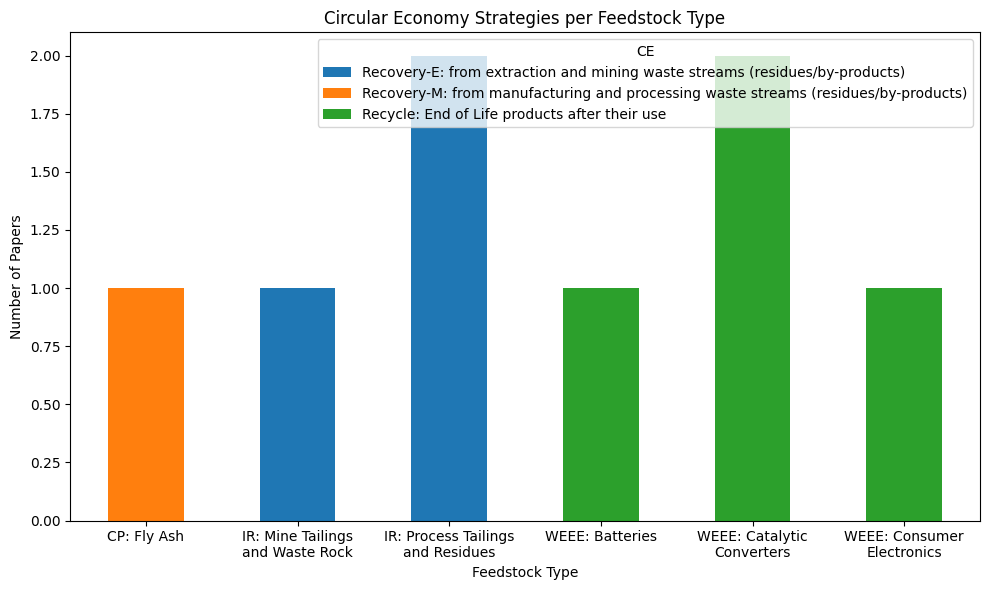

In [96]:
# ----- Figure 2: CE Strategy Stacked Bar -----
# Detect CE Strategy column
ce_col = [c for c in df_melted.columns if 'economy' in c.lower() and 'strategy' in c.lower()][0]

df_ce = df_melted[[sec_cat_col, ce_col]].dropna()
df_ce = df_ce.assign(
    CE=df_ce[ce_col].str.split(';')
).explode('CE')
df_ce['CE'] = df_ce['CE'].str.strip()

count_ce = df_ce.groupby([sec_cat_col, 'CE']).size().unstack(fill_value=0)

fig2, ax2 = plt.subplots(figsize=(10, 6))
count_ce.plot(kind='bar', stacked=True, ax=ax2)
ax2.set_xlabel('Feedstock Type')
ax2.set_ylabel('Number of Papers')
ax2.set_title('Circular Economy Strategies per Feedstock Type')
ax2.set_xticklabels([
    "\n".join(textwrap.wrap(lbl, width=20)) for lbl in count_ce.index
], rotation=0)
plt.tight_layout()
plt.show()

In [97]:
import pandas as pd

# Export the full melted dataset to a CSV file for full record
df_melted.to_csv('melted_consensus.csv', index=False)


# In Colab: download both CSVs to your local machine
from google.colab import files
files.download('melted_consensus.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [98]:
# 2. Define blocks
metadata = df_consensus.columns[:11]
feed1 = df_consensus.columns[11:123]
feed2 = df_consensus.columns[123:235]
feed3 = df_consensus.columns[235:347]
section4 = df_consensus.columns[347:]

# 3. Melt feedstocks into long form
rows = []
for _, row in df_consensus.iterrows():
    for block in (feed1, feed2, feed3):
        if row[block].notna().any():
            rec = {c: row[c] for c in metadata}
            for i, col in enumerate(feed1):
                rec[col] = row[block[i]]
            for c in section4:
                rec[c] = row[c]
            rows.append(rec)
df_melted = pd.DataFrame(rows, columns=list(metadata) + list(feed1) + list(section4))

# 4. Conversion helper to normalize concentrations to ppm
def to_ppm(val, unit):
    if pd.isna(val): return pd.NA
    s = str(val).replace(',', '').strip()
    try: v = float(s)
    except: return pd.NA
    u = str(unit).lower()
    if u in ['ppm','mg/kg']: return v
    if u == 'g/kg': return v * 1000
    if '%'  in u: return v * 10000
    return pd.NA

# 5. Build converted DataFrame and collect original REE columns to drop
df_conv = df_melted.copy()
drop_cols = []
for idx, conc_col in enumerate(feed1):
    if 'REE conc. in feedstock' not in conc_col:
        continue
    code = conc_col.split('(')[1].split(')')[0]
    # Identify neighboring columns: unit, purity, purity unit, yield, yield unit
    unit_col        = feed1[idx+1]
    purity_col      = feed1[idx+2]
    purity_unit_col = feed1[idx+3]
    yield_col       = feed1[idx+4]
    yield_unit_col  = feed1[idx+5]
    # Create simplified metrics
    df_conv[f'{code}_conc_ppm']   = df_conv.apply(lambda r: to_ppm(r[conc_col], r[unit_col]), axis=1)
    # Convert to string before applying .str accessor
    df_conv[f'{code}_purity_pct'] = pd.to_numeric(df_conv[purity_col].astype(str).str.rstrip('%'), errors='coerce')
    df_conv[f'{code}_yield_pct']  = pd.to_numeric(df_conv[yield_col].astype(str).str.rstrip('%'), errors='coerce')
    # Mark original columns for removal
    drop_cols += [conc_col, unit_col, purity_col, purity_unit_col, yield_col, yield_unit_col]

# 6. Drop original REE columns and build final aligned table
keep_cols = [c for c in df_conv.columns if c not in drop_cols]
df_final = df_conv[keep_cols]

# 7. View the table interactively
#from google.colab.data_table import DataTable
#DataTable(df_final, include_index=False, num_rows_per_page=10)



# Merge Numerical Results


In [99]:
from IPython.display import display

# Allow pandas to print unlimited columns, then display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)      # or larger if you want more horizontal space
display(df_final)

,Covidence #,Study ID,Title,Reviewer Name,Paper Title,Journal Name,Year of Publication,Author Institutions,Institutions' Countries,Study design,REEs Studied,Geographic source - FIRST FEEDSTOCK,Main Category - FIRST FEEDSTOCK,Secondary Category - FIRST FEEDSTOCK,REEs Recovered - First Feedstock:,Extraction Method,Co-/By-Products during Recovery,Circular Economy Strategy,Lifecycle Stage of Intervention,Key Feedstock Logistical,Economic Information,Additional Notes,Ce_conc_ppm,Ce_purity_pct,Ce_yield_pct,Dy_conc_ppm,Dy_purity_pct,Dy_yield_pct,Er_conc_ppm,Er_purity_pct,Er_yield_pct,Eu_conc_ppm,Eu_purity_pct,Eu_yield_pct,Gd_conc_ppm,Gd_purity_pct,Gd_yield_pct,Ho_conc_ppm,Ho_purity_pct,Ho_yield_pct,La_conc_ppm,La_purity_pct,La_yield_pct,Lu_conc_ppm,Lu_purity_pct,Lu_yield_pct,Nd_conc_ppm,Nd_purity_pct,Nd_yield_pct,Pm_conc_ppm,Pm_purity_pct,Pm_yield_pct,Pr_conc_ppm,Pr_purity_pct,Pr_yield_pct,Sc_conc_ppm,Sc_purity_pct,Sc_yield_pct,Sm_conc_ppm,Sm_purity_pct,Sm_yield_pct,Tb_conc_ppm,Tb_purity_pct,Tb_yield_pct,Tm_conc_ppm,Tm_purity_pct,Tm_yield_pct,Y_conc_ppm,Y_purity_pct,Y_yield_pct,Yb_conc_ppm,Yb_purity_pct,Yb_yield_pct,General_conc_ppm,General_purity_pct,General_yield_pct
0,586,AboAtia 2021,Microwave chloride leaching of valuable elemen...,Consensus,Microwave chloride leaching of valuable elemen...,"Resources, Conservation & Recycling",2021,"Waste Recycling Technologies, Flemish Institut...",Belgium; Italy,Experimental (Lab Study),Cerium (Ce); Lanthanum (La); Neodymium (Nd); Y...,Other: Greece,EoL Products and Electronic Waste (WEEE),WEEE: Catalytic Converters,NaN,"Hydrometallurgy (acid leaching, ion-exchange, ...",Platinum group metals (PGMs),Recycle: End of Life products after their use,End of Life Processing,spent automotive ceramic catalysts; discountin...,NaN,NaN,27600.0,NaN,82.0,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,74.5,<NA>,NaN,NaN,909.0,NaN,99.0,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,127.0,NaN,26.0,<NA>,NaN,NaN,<NA>,NaN,NaN
1,586,AboAtia 2021,Microwave chloride leaching of valuable elemen...,Consensus,Microwave chloride leaching of valuable elemen...,"Resources, Conservation & Recycling",2021,"Waste Recycling Technologies, Flemish Institut...",Belgium; Italy,Experimental (Lab Study),Cerium (Ce); Lanthanum (La); Neodymium (Nd); Y...,Other: Turkey; Italy,EoL Products and Electronic Waste (WEEE),WEEE: Catalytic Converters,NaN,"Hydrometallurgy (acid leaching, ion-exchange, ...",Platinum group metals (PGMs),Recycle: End of Life products after their use,End of Life Processing,spent automotive ceramic catalysts; discountin...,NaN,NaN,34000.0,NaN,88.5,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,60.0,<NA>,NaN,NaN,655.0,NaN,62.0,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,2259.0,NaN,27.0,<NA>,NaN,NaN,<NA>,NaN,NaN
2,493,AbouEl‑Anwar 2025,Mining and industrial processing wastes of pho...,Consensus,Mining and industrial processing wastes of pho...,International Journal of Environmental Science...,2025,National Research Centre; Ministry of Environm...,Egypt; China,Experimental (Lab Study); Economic Assessment ...,Cerium (Ce); Lanthanum (La); Neodymium (Nd); S...,Other: Egypt,Industrial Residues (IR),IR: Mine Tailings and Waste Rock,NaN,"Physical (magnetic separation, microwaves, fib...",toxic metals,Recovery-E: from extraction and mining waste s...,Extraction/Mining; Processing/Refining,Lack of REE separation processes,Abu Tartur wastes rocks (1920.1 gm/tone for RE...,NaN,114.0,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,59.0,NaN,NaN,<NA>,NaN,NaN,64.0,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,28.0,NaN,NaN,13.0,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,106.0,NaN,NaN,<NA>,NaN,NaN,<NA>,NaN,NaN
3,493,AbouEl‑Anwar 2025,Mining and industrial processing wastes of pho...,Consensus,Mining and industrial processing wastes of pho...,International Journal of Environmental Science...,2025,National Researc

<ipython-input-100-3478227284>:25: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



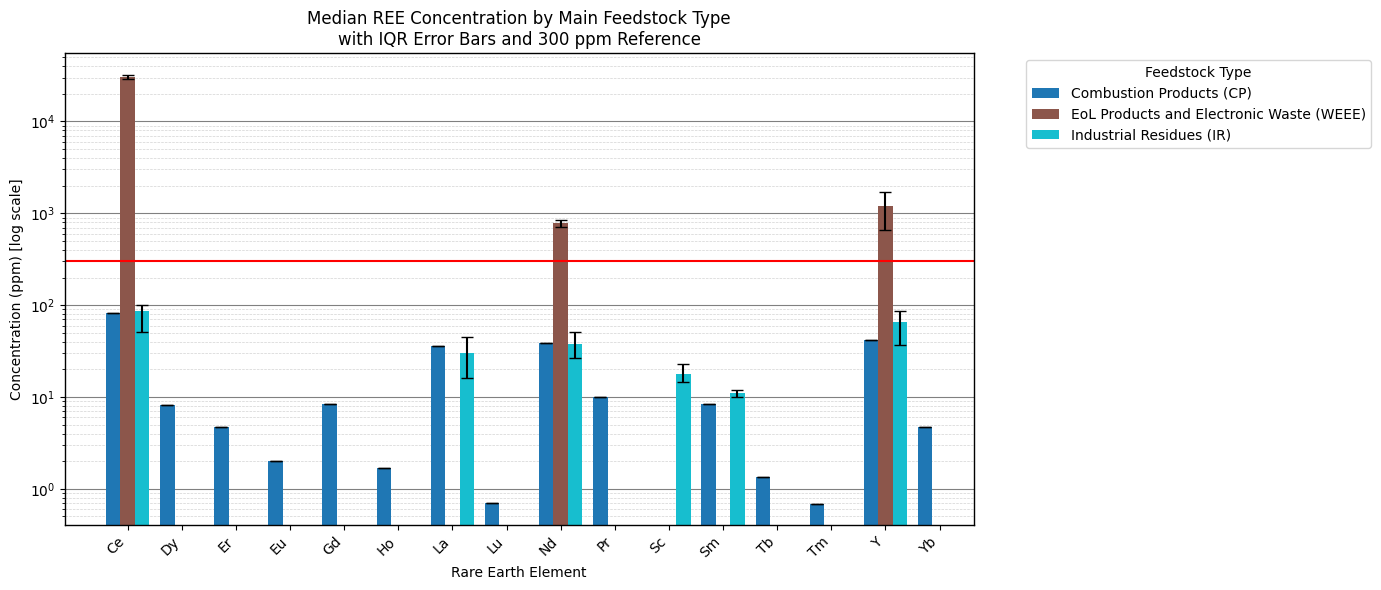

In [100]:
# 2. Identify grouping and REE concentration columns
group_col = [c for c in df_final.columns if 'Main Category' in c][0]
conc_cols = [c for c in df_final.columns if c.endswith('_conc_ppm')]

# 3. Melt to long format
df_long = df_final[[group_col] + conc_cols].melt(
    id_vars=group_col, value_vars=conc_cols,
    var_name='REE', value_name='ppm'
)
df_long['REE'] = df_long['REE'].str.replace('_conc_ppm', '')
df_long['ppm'] = pd.to_numeric(df_long['ppm'], errors='coerce')
df_long = df_long.dropna(subset=['ppm'])

# 4. Compute IQR percentiles
quantiles = df_long.groupby(['REE', group_col])['ppm'] \
    .quantile([0.25, 0.5, 0.75]).unstack(level=-1)
quantiles.columns = ['q1', 'median', 'q3']

# 5. Plot setup
rees = quantiles.index.get_level_values(0).unique()
feeds = quantiles.index.get_level_values(1).unique()
spacing = 1.5
x = np.arange(len(rees)) * spacing
width = (spacing * 0.8) / len(feeds)
colors = plt.cm.get_cmap('tab10', len(feeds))

fig, ax = plt.subplots(figsize=(14, 6))
for i, fs in enumerate(feeds):
    subset = quantiles.xs(fs, level=1).reindex(rees)
    med = subset['median']
    err_lower = med - subset['q1']
    err_upper = subset['q3'] - med
    ax.bar(
        x + i*width, med, width, label=fs, color=colors(i),
        yerr=[err_lower, err_upper], capsize=4
    )

# 6. Log scale & gridlines
ax.set_yscale('log')
ax.yaxis.set_major_locator(LogLocator(base=10.0))
ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(1, 10)*0.1))
ax.grid(which='major', axis='y', linestyle='-', linewidth=0.8, color='gray')
ax.grid(which='minor', axis='y', linestyle='--', linewidth=0.5, color='lightgray')
ax.set_axisbelow(True)

# 7. Reference line at 300 ppm
ax.axhline(300, color='red', linewidth=1.5)

# 8. Close all spines
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)

# 9. Labels & legend
ax.set_xticks(x + (len(feeds)-1)*width/2)
ax.set_xticklabels(rees, rotation=45, ha='right')
ax.set_xlabel('Rare Earth Element')
ax.set_ylabel('Concentration (ppm) [log scale]')
ax.set_title('Median REE Concentration by Main Feedstock Type\nwith IQR Error Bars and 300 ppm Reference')
ax.legend(title='Feedstock Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<ipython-input-101-913259725>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-101-913259725>:19: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



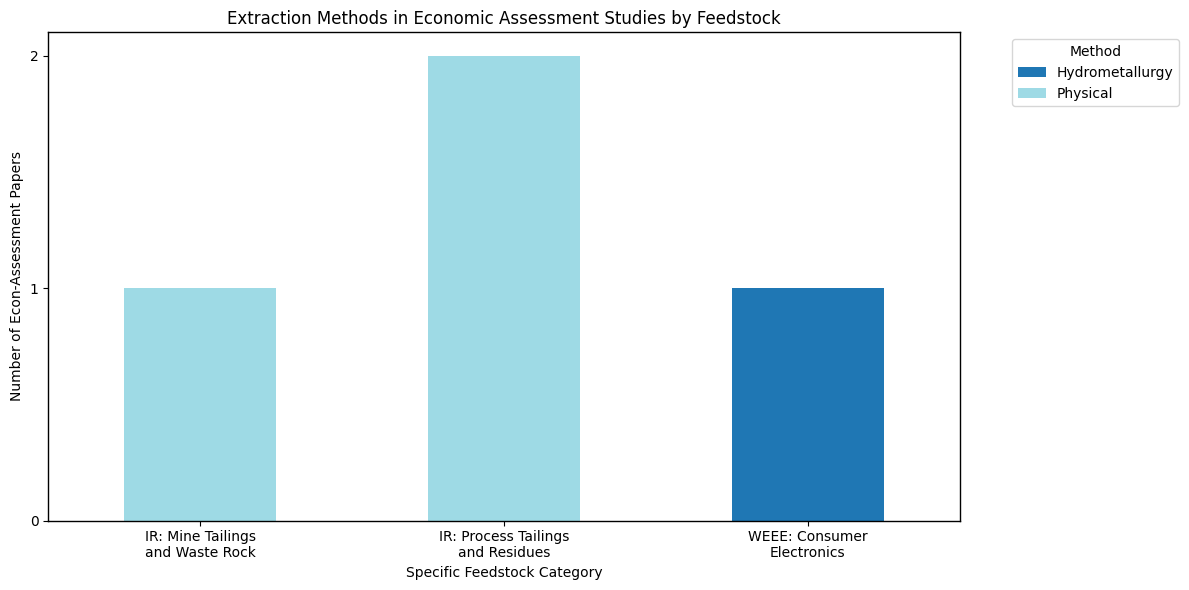

<ipython-input-101-913259725>:46: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



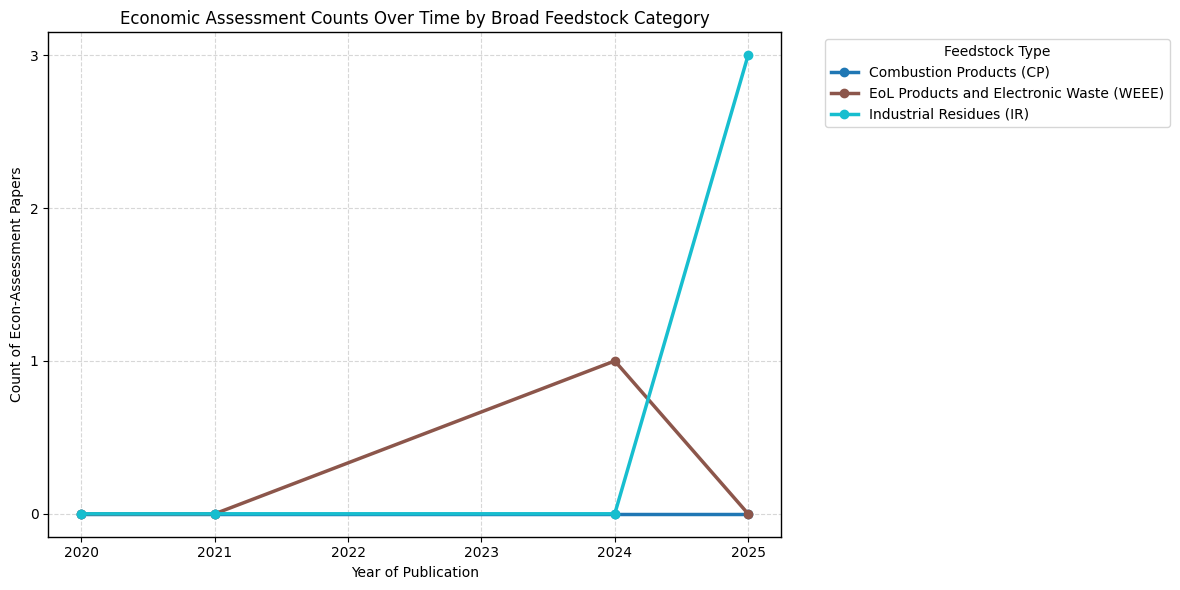

In [101]:

# Flag Economic Assessment
df_final['has_econ'] = df_final['Study design'].fillna('').str.contains('Economic Assessment', case=False)

# 1) Bar chart: Extraction methods for econ‐assessment studies
sec_cat = [c for c in df_final.columns if 'Secondary Category' in c][0]
ext_col = [c for c in df_final.columns if 'Extraction Method' in c][0]

df_bar = (
    df_final[df_final['has_econ']]
    [[sec_cat, ext_col]]
    .dropna(subset=[ext_col])
    .assign(Extraction=lambda d: d[ext_col].str.split(';'))
    .explode('Extraction')
)
df_bar['Extraction'] = df_bar['Extraction'].str.strip().str.replace(r'\s*\(.*\)', '', regex=True)
count_bar = df_bar.groupby([sec_cat, 'Extraction']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(12,6))
colors = plt.cm.get_cmap('tab20', count_bar.shape[1])
count_bar.plot(
    kind='bar', stacked=True, ax=ax,
    color=[colors(i) for i in range(count_bar.shape[1])]
)
ax.set_xticklabels(
    ["\n".join(textwrap.wrap(lbl, width=20)) for lbl in count_bar.index],
    rotation=0
)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
for sp in ax.spines.values(): sp.set_color('black'); sp.set_linewidth(1)
ax.set_xlabel('Specific Feedstock Category')
ax.set_ylabel('Number of Econ-Assessment Papers')
ax.set_title('Extraction Methods in Economic Assessment Studies by Feedstock')
ax.legend(title='Method', bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

# 2) Line chart: Counts over time
year = 'Year of Publication'
main_cat = [c for c in df_final.columns if 'Main Category' in c and 'FIRST' in c][0]

df_line = df_final.dropna(subset=[year]).copy()
df_line[year] = df_line[year].astype(int)
grp = df_line.groupby([year, main_cat])['has_econ'].sum().unstack(fill_value=0)

fig2, ax2 = plt.subplots(figsize=(12,6))
colors2 = plt.cm.get_cmap('tab10', grp.shape[1])
for i, cat in enumerate(grp.columns):
    ax2.plot(
        grp.index, grp[cat], marker='o', label=cat,
        color=colors2(i), linewidth=2.5
    )
ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
for sp in ax2.spines.values(): sp.set_color('black'); sp.set_linewidth(1)
ax2.set_xlabel('Year of Publication')
ax2.set_ylabel('Count of Econ-Assessment Papers')
ax2.set_title('Economic Assessment Counts Over Time by Broad Feedstock Category')
ax2.legend(title='Feedstock Type', bbox_to_anchor=(1.05,1), loc='upper left')
ax2.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [102]:
# 1. Filter for econ‐assessment studies
econ_df = df_final[df_final['has_econ']].copy()

# 2. Export to CSV
econ_df.to_csv('econ_assessment_papers.csv', index=False)
print("Saved econ_assessment_papers.csv with", len(econ_df), "rows.")

# 3. (Optional) Download to your local machine
from google.colab import files
files.download('econ_assessment_papers.csv')


Saved econ_assessment_papers.csv with 4 rows.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# CE Strategies

In [103]:
# Identify columns
sec_cat_col = [c for c in df_final.columns if 'Secondary Category' in c][0]
extract_col = [c for c in df_final.columns if 'Extraction Method' in c][0]
ce_col      = [c for c in df_final.columns if 'economy' in c.lower() and 'strategy' in c.lower()][0]

# ======================
# Option 4: CE Strategy vs Economic Assessment
# ======================
#df_ce = df_final[[ce_col, 'has_econ']].dropna(subset=[ce_col]).copy()
#df_ce['Strategy'] = df_ce[ce_col].str.split(';').apply(lambda lst: [s.strip() for s in lst] if isinstance(lst, list) else [])
#df_ce = df_ce.explode('Strategy')

#count_ce = df_ce.groupby(['Strategy', 'has_econ']).size().unstack(fill_value=0)

# Plot grouped bar
#fig1, ax1 = plt.subplots(figsize=(8, 5))
#count_ce.plot(kind='bar', ax=ax1, color=['lightgray', 'tab:blue'])
#ax1.yaxis.set_major_locator(MaxNLocator(integer=True))
#for sp in ax1.spines.values():
#    sp.set_color('black'); sp.set_linewidth(1)
#ax1.set_xlabel('Circular Economy Strategy')
#ax1.set_ylabel('Number of Papers')
#ax1.set_title('Economic Assessment by CE Strategy')
#ax1.legend(['No Econ Assessment', 'Has Econ Assessment'], title='Econ', loc='upper right')
#plt.xticks(rotation=45, ha='right')
#plt.tight_layout()
#plt.show()

# ======================
# Option 3: Sankey Diagram
# ======================
df_sankey = df_final[[sec_cat_col, ce_col, extract_col]].dropna().copy()
df_sankey = df_sankey.assign(
    Strategy = df_sankey[ce_col].str.split(';'),
    Extraction = df_sankey[extract_col].str.split(';')
).explode('Strategy').explode('Extraction')

df_sankey['Extraction'] = df_sankey['Extraction'].str.strip().str.replace(r'\s*\(.*\)', '', regex=True)
df_sankey['Strategy']   = df_sankey['Strategy'].str.strip()

flow1 = df_sankey.groupby([sec_cat_col, 'Strategy']).size().reset_index(name='value')
flow2 = df_sankey.groupby(['Strategy', 'Extraction']).size().reset_index(name='value')

nodes = list(pd.unique(flow1[sec_cat_col].tolist() + flow1['Strategy'].tolist() + flow2['Extraction'].tolist()))

flow1['source'] = flow1[sec_cat_col].apply(lambda x: nodes.index(x))
flow1['target'] = flow1['Strategy'].apply(lambda x: nodes.index(x))
flow2['source'] = flow2['Strategy'].apply(lambda x: nodes.index(x))
flow2['target'] = flow2['Extraction'].apply(lambda x: nodes.index(x))

links = pd.concat([flow1, flow2], ignore_index=True)

fig2 = go.Figure(go.Sankey(
    node = dict(label = nodes, pad=15, thickness=20, line=dict(color='black', width=1)),
    link = dict(
        source = links['source'],
        target = links['target'],
        value  = links['value'],
        color  = 'lightblue'
    )
))
fig2.update_layout(title_text="Feedstock → CE Strategy → Extraction Method", font_size=10)
fig2.show()

# ===================================

# assume df_final exists
sec_cat = [c for c in df_final.columns if 'Secondary Category' in c][0]
ce_col  = [c for c in df_final.columns if 'strategy' in c.lower()][0]
stage_col = 'Lifecycle Stage of Intervention'   # replace with the exact column name you have

# explode & clean
df_sk = (
    df_final[[sec_cat, stage_col, ce_col]]
    .dropna(subset=[sec_cat, stage_col, ce_col])
    .assign(
      Strategy = lambda d: d[ce_col].str.split(';'),
      Stage    = lambda d: d[stage_col].str.split(';')
    )
    .explode('Stage').explode('Strategy')
)
df_sk['Strategy'] = df_sk['Strategy'].str.strip()
df_sk['Stage']    = df_sk['Stage'].str.strip()

# build flows
f1 = (df_sk.groupby([sec_cat, 'Stage'])
        .size().reset_index(name='value'))
f2 = (df_sk.groupby(['Stage', 'Strategy'])
        .size().reset_index(name='value'))

labels = list(pd.unique(
    f1[sec_cat].tolist() + f1['Stage'].tolist() + f2['Strategy'].tolist()
))
# map to indices
for dfw, src, tgt in [(f1, sec_cat, 'Stage'), (f2, 'Stage', 'Strategy')]:
    dfw['source'] = dfw[src].apply(lambda x: labels.index(x))
    dfw['target'] = dfw[tgt].apply(lambda x: labels.index(x))

links = pd.concat([f1, f2], ignore_index=True)
fig = go.Figure(go.Sankey(
    node=dict(label=labels, pad=15, thickness=20,
              line=dict(color='black', width=1)),
    link=dict(source=links['source'],
              target=links['target'],
              value=links['value'])
))
fig.update_layout(title_text="Feedstock → Lifecycle Stage → CE Strategy", font_size=10)
fig.show()





<ipython-input-103-2623294831>:44: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



<ipython-input-103-2623294831>:91: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.



            Main Category - FIRST FEEDSTOCK Secondary Category - FIRST FEEDSTOCK REE                                Typical_CE_Strategy           Typical_Co_products Typical_Extraction_Methods  \
0  EoL Products and Electronic Waste (WEEE)           WEEE: Catalytic Converters  Ce      Recycle: End of Life products after their use  Platinum group metals (PGMs)            Hydrometallurgy   
1  EoL Products and Electronic Waste (WEEE)           WEEE: Catalytic Converters  Nd      Recycle: End of Life products after their use  Platinum group metals (PGMs)            Hydrometallurgy   
2  EoL Products and Electronic Waste (WEEE)           WEEE: Catalytic Converters   Y      Recycle: End of Life products after their use  Platinum group metals (PGMs)            Hydrometallurgy   
3                  Industrial Residues (IR)     IR: Mine Tailings and Waste Rock  Ce  Recovery-E: from extraction and mining waste s...                  toxic metals                   Physical   
4                  I

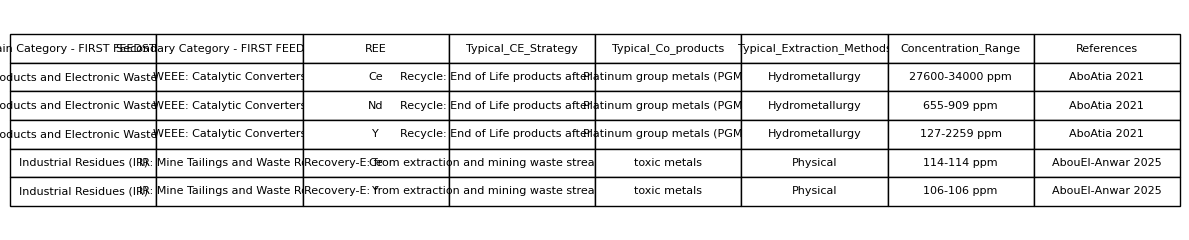

In [104]:
# 1. Identify key columns
prim_col   = 'Main Category - FIRST FEEDSTOCK'
sec_col    = 'Secondary Category - FIRST FEEDSTOCK'
study_col  = 'Study ID'
ce_col     = [c for c in df_final.columns if 'strategy' in c.lower() and 'circular' in c.lower()][0]
co_col     = [c for c in df_final.columns if 'Co-' in c and 'Products' in c][0]
extract_col= [c for c in df_final.columns if 'Extraction Method' in c][0]

# 2. Melt and filter concentrations >=100 ppm
conc_cols = [c for c in df_final.columns if c.endswith('_conc_ppm')]
df_conc2 = df_final.melt(
    id_vars=[prim_col, sec_col, study_col, ce_col, co_col, extract_col],
    value_vars=conc_cols,
    var_name='REE', value_name='conc_ppm'
).dropna(subset=['conc_ppm'])
df_conc2['conc_ppm'] = pd.to_numeric(df_conc2['conc_ppm'], errors='coerce')
df_conc2 = df_conc2[df_conc2['conc_ppm'] >= 100]
df_conc2['REE'] = df_conc2['REE'].str.replace('_conc_ppm','')

# 3. Aggregation helper
def combine_unique(series, splitter=';'):
    items = series.dropna().astype(str).str.split(';').explode().str.strip()
    return splitter.join(items.unique())

# 4. Group and summarize
summary_by_ree = df_conc2.groupby([prim_col, sec_col, 'REE']).agg(
    Typical_CE_Strategy       = (ce_col, combine_unique),
    Typical_Co_products       = (co_col, combine_unique),
    Typical_Extraction_Methods= (extract_col, lambda s: combine_unique(s.str.replace(r'\s*\(.*\)', '', regex=True))),
    Concentration_Range       = ('conc_ppm', lambda x: f"{int(x.min())}-{int(x.max())} ppm"),
    References                = (study_col, lambda s: ';'.join(sorted(s.unique())))
).reset_index()

# 5. Export or display
summary_by_ree.to_csv('feedstock_ree_summary_100ppm.csv', index=False)
print(summary_by_ree)

# =====-=-=====

# 3. Render and save as PNG figure for insertion as an image
fig, ax = plt.subplots(figsize=(12, len(summary_by_ree)*0.3 + 1))
ax.axis('off')
tbl = ax.table(
    cellText=summary_by_ree.values,
    colLabels=summary_by_ree.columns,
    cellLoc='center',
    loc='center'
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(8)
tbl.scale(1, 1.5)
plt.tight_layout()
plt.savefig('feedstock_ree_summary_100ppm.png', dpi=300, bbox_inches='tight')
print("Saved table as image to feedstock_ree_summary_100ppm.png.")


Saved styled table as feedstock_summary_styled.png (dpi=300)


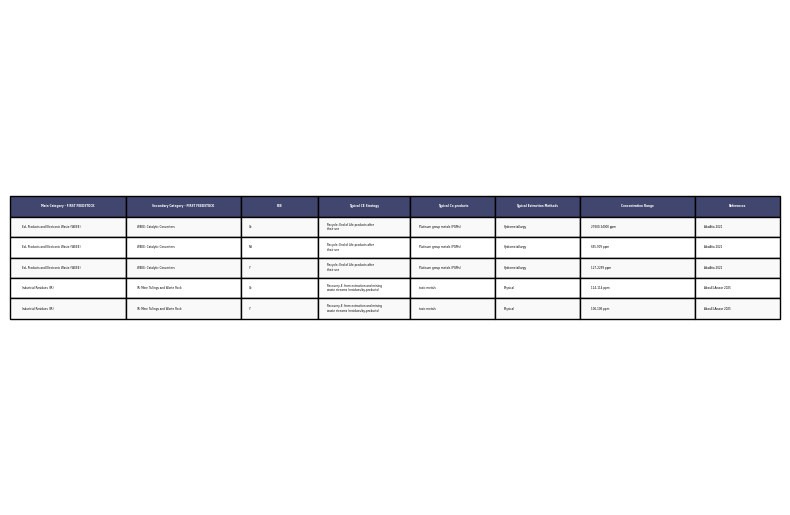

In [105]:
# --- CONFIGURABLE PARAMETERS ---
wrap_width      = 40   # max chars per line before wrapping
fig_width       = 8   # figure width in inches
row_height_mult = 0.85  # multiplier for row height
header_fontsize = 14   # font size for header text
cell_fontsize   = 38    # font size for cell text
col_widths      = [0.15, 0.15, 0.10, 0.12, 0.110, 0.110, 0.15, 0.11]  # relative widths for 8 columns
scale_x         = 1.0  # table scale in X direction (cell width multiplier)
scale_y         = 1.0  # table scale in Y direction (cell height multiplier)
output_dpi      = 300  # resolution for saved PNG

# Assume 'summary_by_ree' DataFrame is already in the Colab environment
df = summary_by_ree.copy()

# --- WRAP CONTENT ---
wrapped = []
for row in df.values:
    wrapped.append([
        "\n".join(textwrap.wrap(str(val), width=wrap_width))
        for val in row
    ])

# Wrap column headers
col_labels = [
    "\n".join(textwrap.wrap(c.replace('_', ' '), width=wrap_width))
    for c in df.columns
]

# --- FIGURE SETUP ---
num_rows = len(df)
fig_height = num_rows * row_height_mult + 1  # dynamic height based on row count
fig, ax = plt.subplots(figsize=(fig_width, fig_height))
ax.axis('off')

# --- CREATE TABLE ---
table = ax.table(
    cellText=wrapped,
    colLabels=col_labels,
    cellLoc='left',
    colWidths=col_widths,
    loc='center'
)

# --- APPLY SCALING ---
table.scale(scale_x, scale_y)

# --- STYLE HEADER & CELLS ---
for (r, c), cell in table.get_celld().items():
    cell.set_edgecolor('black')
    if r == 0:
        # Header style
        cell.set_facecolor('#40466e')
        cell.set_text_props(weight='bold', color='white', fontsize=header_fontsize)
    else:
        # Alternate row shading
        cell.set_facecolor('#f9f9f9' if r % 2 else 'white')
        cell.set_text_props(fontsize=cell_fontsize)

# --- SAVE TO PNG ---
output_file = 'feedstock_summary_styled.png'
plt.tight_layout()
plt.savefig(output_file, dpi=output_dpi, bbox_inches='tight')
print(f"Saved styled table as {output_file} (dpi={output_dpi})")

In [106]:
import pandas as pd
import plotly.express as px

# --- 1) Prepare the data ---
geo_col = 'Geographic source - FIRST FEEDSTOCK'
feed_col = 'Main Category - FIRST FEEDSTOCK'

# Use df_melted from your prior steps; if not present, rebuild it
# df_melted = ...

# Group and count
df_map = (
    df_melted
    .groupby([geo_col, feed_col])
    .size()
    .reset_index(name='count')
)

# --- 2) Plot with Plotly ---
fig = px.scatter_geo(
    df_map,
    locations=geo_col,
    locationmode='country names',
    color=feed_col,
    size='count',
    hover_name=geo_col,
    projection='natural earth',
    title='Geographic Hotspots of Alternative REE Feedstocks (with more than 100ppm)'
)
fig.update_layout(legend_title_text='Feedstock Type')
fig.show()


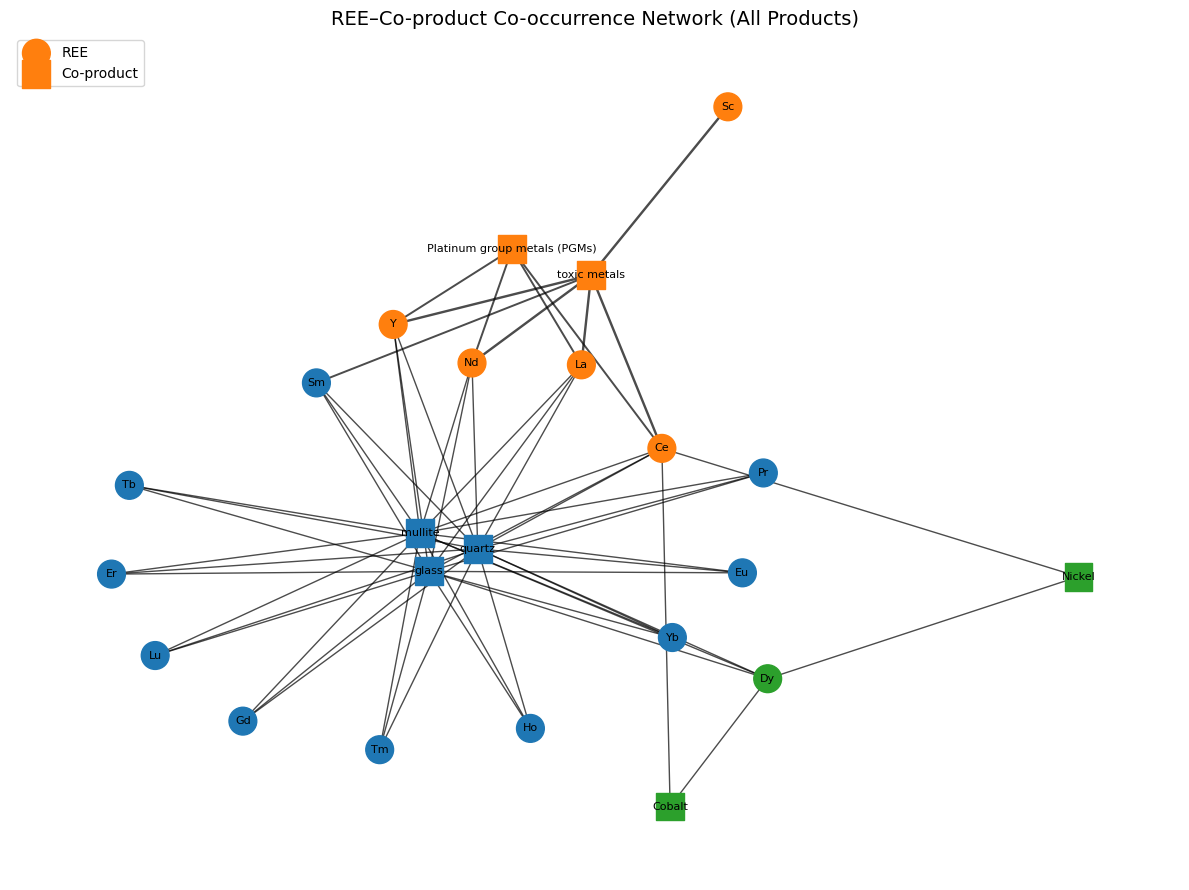

In [107]:
import re
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import community

# 1) Start from your df_melted (one row per paper×feedstock, before any conc_ppm filtering)
#    It must still have the original concentration columns and the original co-products column.

# Identify the original concentration columns:
conc_cols_orig = [c for c in df_melted.columns if 'REE conc. in feedstock' in c]

# Identify the co-products column:
co_col = [c for c in df_melted.columns if 'Co-' in c and 'Products' in c][0]

# 2) Build edge counts by iterating over each row:
edge_counts = {}
for _, row in df_melted.iterrows():
    # 2a) Which REEs were measured?
    measured = []
    for c in conc_cols_orig:
        val = row[c]
        if pd.notna(val) and str(val).strip() not in ['', 'NaN']:
            # extract the element code, e.g. "Cerium (Ce)" → "Ce"
            code = re.search(r'\((\w+)\)', c).group(1)
            measured.append(code)
    if not measured:
        continue

    # 2b) Split out each co-product (commas or semicolons)
    raw = row[co_col]
    if pd.isna(raw):
        continue
    cops = [x.strip() for x in re.split(r'[;,]', str(raw)) if x.strip()]

    # 2c) Tally each pairing
    for e in measured:
        for p in cops:
            edge_counts[(e, p)] = edge_counts.get((e,p), 0) + 1

# 3) Turn that into a DataFrame
edges = pd.DataFrame(
    [(*k, w) for k, w in edge_counts.items()],
    columns=['REE','CoProduct','weight']
)

# 4) Build the bipartite graph
G = nx.Graph()
rees    = edges['REE'].unique()
coprods = edges['CoProduct'].unique()
G.add_nodes_from(rees,    bipartite=0)
G.add_nodes_from(coprods, bipartite=1)
for _, row in edges.iterrows():
    G.add_edge(row['REE'], row['CoProduct'], weight=row['weight'])

# 5) Community detection for coloring
comms = community.greedy_modularity_communities(G, weight='weight')
color_map = {}
for i, comm in enumerate(comms):
    for n in comm:
        color_map[n] = f"C{i % 10}"  # cycle through 10 default Matplotlib colors

# 6) Draw with a spring layout (more robust than bipartite)
pos = nx.spring_layout(G, k=0.8, seed=42)
plt.figure(figsize=(12, 9))

nx.draw_networkx_nodes(
    G, pos,
    nodelist=rees,
    node_color=[color_map[n] for n in rees],
    node_shape='o', node_size=400,
    label='REE'
)
nx.draw_networkx_nodes(
    G, pos,
    nodelist=coprods,
    node_color=[color_map[n] for n in coprods],
    node_shape='s', node_size=400,
    label='Co-product'
)
nx.draw_networkx_edges(
    G, pos,
    width=[max(1, data['weight']**0.5) for _,_,data in G.edges(data=True)],
    alpha=0.7
)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title('REE–Co-product Co-occurrence Network (All Products)', fontsize=14)
plt.axis('off')
plt.legend(scatterpoints=1, loc='upper left')
plt.tight_layout()
plt.show()


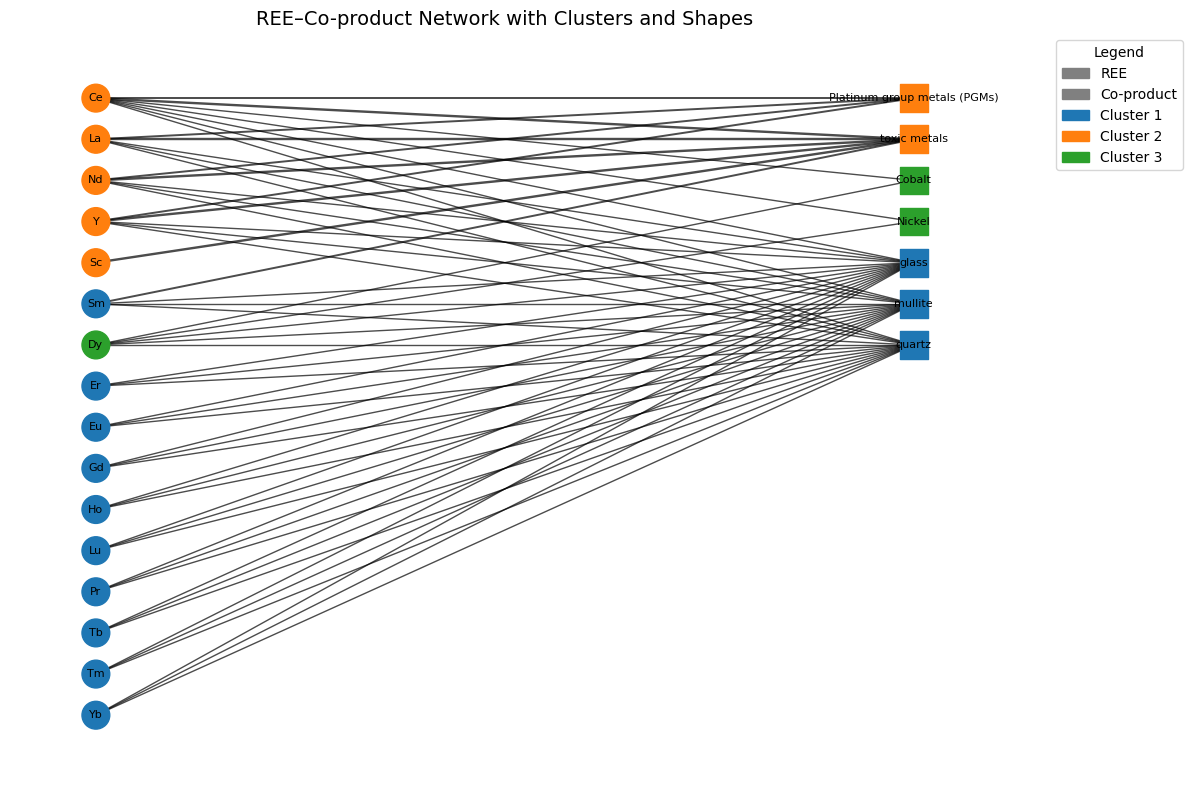

In [108]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from networkx.algorithms import community

# --- Prepare data for REE–Co-product network (all consensus rows) ---
conc_cols_orig = [c for c in df_melted.columns if 'REE conc. in feedstock' in c]
co_col = [c for c in df_melted.columns if 'Co-' in c and 'Products' in c][0]

# Build edge counts
import re
edge_counts = {}
for _, row in df_melted.iterrows():
    # Identify measured REEs
    measured = []
    for c in conc_cols_orig:
        if pd.notna(row[c]) and str(row[c]).strip():
            code = re.search(r'\((\w+)\)', c).group(1)
            measured.append(code)
    if not measured:
        continue
    # Split co-products
    raw = row[co_col]
    if pd.isna(raw):
        continue
    cops = [x.strip() for x in re.split(r'[;,]', str(raw)) if x.strip()]
    # Tally
    for e in measured:
        for p in cops:
            edge_counts[(e, p)] = edge_counts.get((e, p), 0) + 1

edges = pd.DataFrame([(*k, w) for k, w in edge_counts.items()],
                     columns=['REE','CoProduct','weight'])

# Build graph
G = nx.Graph()
rees = edges['REE'].unique()
coprods = edges['CoProduct'].unique()
G.add_nodes_from(rees, bipartite=0)
G.add_nodes_from(coprods, bipartite=1)
for _, r in edges.iterrows():
    G.add_edge(r['REE'], r['CoProduct'], weight=r['weight'])

# Community detection for coloring
comms = community.greedy_modularity_communities(G, weight='weight')
color_map = {}
for i, comm in enumerate(comms):
    for node in comm:
        color_map[node] = plt.cm.tab10(i % 10)

# Use bipartite layout: REEs on left, Co-products on right
pos = {}
# Left column x=0
for i, n in enumerate(rees):
    pos[n] = (0, -i)
# Right column x=1
for j, n in enumerate(coprods):
    pos[n] = (1, -j)

# Plot
plt.figure(figsize=(12, 8))
# REE nodes
nx.draw_networkx_nodes(G, pos,
                       nodelist=rees,
                       node_color=[color_map[n] for n in rees],
                       node_shape='o',
                       node_size=400,
                       label='REE')
# Co-product nodes
nx.draw_networkx_nodes(G, pos,
                       nodelist=coprods,
                       node_color=[color_map[n] for n in coprods],
                       node_shape='s',
                       node_size=400,
                       label='Co-product')
# Edges
nx.draw_networkx_edges(G, pos,
                       width=[max(1, w['weight']**0.5) for _,_,w in G.edges(data=True)],
                       alpha=0.7)
# Labels
nx.draw_networkx_labels(G, pos, font_size=8)

# Legend: node shapes
circle = mpatches.Patch(color='gray', label='REE', linestyle='None')
square = mpatches.Patch(color='gray', label='Co-product', linestyle='None')
# Legend: communities
comm_patches = [mpatches.Patch(color=plt.cm.tab10(i % 10),
                               label=f'Cluster {i+1}')
                for i in range(len(comms))]
plt.legend(handles=[circle, square] + comm_patches,
           title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('REE–Co-product Network with Clusters and Shapes', fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

In [109]:
# --- Sankey: Feedstock → REE → Co-product ---
import plotly.graph_objects as go

# Prepare flows
sec_cat = 'Secondary Category - FIRST FEEDSTOCK'
# Re-use edge_counts but need counts for feedstock→REE and REE→CoProduct
# Feedstock→REE counts
flow1 = (df_melted
         .melt(id_vars=[sec_cat], value_vars=conc_cols_orig, var_name='REE_raw', value_name='val')
         .dropna(subset=['val'])
         .assign(REE=lambda d: d['REE_raw'].str.extract(r'\((\w+)\)')[0])
         .groupby([sec_cat, 'REE'])['val'].count()
         .reset_index(name='value'))

# REE→CoProduct flow from edges DataFrame
flow2 = edges.rename(columns={'weight':'value'})

# Build node list
nodes = list(pd.unique(flow1[sec_cat].tolist() +
                       flow1['REE'].tolist() +
                       flow2['CoProduct'].tolist()))

# Map to indices
flow1['source'] = flow1[sec_cat].apply(lambda x: nodes.index(x))
flow1['target'] = flow1['REE'].apply(lambda x: nodes.index(x))
flow2['source'] = flow2['REE'].apply(lambda x: nodes.index(x))
flow2['target'] = flow2['CoProduct'].apply(lambda x: nodes.index(x))

links = dict(source=flow1['source'].tolist() + flow2['source'].tolist(),
             target=flow1['target'].tolist() + flow2['target'].tolist(),
             value=flow1['value'].tolist() + flow2['value'].tolist())

fig = go.Figure(go.Sankey(
    node=dict(label=nodes, pad=15, thickness=20, line=dict(color='black', width=1)),
    link=links))
fig.update_layout(title_text="Feedstock → REE → Co-product Sankey", font_size=10)
fig.show()

<ipython-input-109-3437628741>:19: FutureWarning:

unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.

